#### Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#### Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-7.5 , 7.5), fill =(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


#### Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

!pwd
!ls data/MNIST


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
/content
processed  raw


#### Dataloader Arguments & Test/Train Dataloaders
Iterable dataloader


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
if cuda:  
  dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True)  
else :
  dataloader_args = dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


#### Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

In [5]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device, use_cuda)

cuda True


### The model
Let's start with the model we first saw

In [0]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Input Block RF =1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 28 RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 28 RF = 5
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 28 RF = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14 RF = 8
        
        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), 
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 12 RF = 12
        
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),  
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 10 RF = 16
        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # output_size = 8 RF = 20

        
    
        # TRANSITION BLOCK 2
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 4 RF = 22
        
  
        # OUTPUT BLOCK 
    
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(26),
            nn.ReLU()
        ) # output_size = 2 RF = 30
    
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=26, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),

        ) # output_size = 2 RF = 30

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=2)
        ) # output_size = 1 RF = 34
  
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool1(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)        
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#### Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [12]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
       BatchNorm2d-2           [-1, 10, 28, 28]              20
              ReLU-3           [-1, 10, 28, 28]               0
            Conv2d-4           [-1, 10, 28, 28]             900
       BatchNorm2d-5           [-1, 10, 28, 28]              20
              ReLU-6           [-1, 10, 28, 28]               0
            Conv2d-7           [-1, 16, 28, 28]           1,440
       BatchNorm2d-8           [-1, 16, 28, 28]              32
              ReLU-9           [-1, 16, 28, 28]               0
          Dropout-10           [-1, 16, 28, 28]               0
        MaxPool2d-11           [-1, 16, 14, 14]               0
           Conv2d-12           [-1, 10, 12, 12]           1,440
      BatchNorm2d-13           [-1, 10, 12, 12]              20
             ReLU-14           [-1, 10,

#### Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss -  negative log likelihood loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

#### Let's Train and test our model

In [14]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch, " LR:", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch)
    t_acc_epoch = test(model, device, test_loader)
    scheduler.step(t_acc_epoch)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0  LR: [0.01]


Loss=0.048449065536260605 Batch_id=468 Accuracy=91.00: 100%|██████████| 469/469 [00:14<00:00, 38.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0961, Accuracy: 9764/10000 (97.64%)

EPOCH: 1  LR: [0.01]


Loss=0.02912946231663227 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:14<00:00, 32.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9877/10000 (98.77%)

EPOCH: 2  LR: [0.01]


Loss=0.05832112953066826 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:14<00:00, 32.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9875/10000 (98.75%)

EPOCH: 3  LR: [0.01]


Loss=0.03266683593392372 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9894/10000 (98.94%)

EPOCH: 4  LR: [0.01]


Loss=0.04254303500056267 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:14<00:00, 32.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9927/10000 (99.27%)

EPOCH: 5  LR: [0.01]


Loss=0.017616262659430504 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9914/10000 (99.14%)

EPOCH: 6  LR: [0.0001]


Loss=0.03644178807735443 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:14<00:00, 32.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0243, Accuracy: 9931/10000 (99.31%)

EPOCH: 7  LR: [0.001]


Loss=0.009801615960896015 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:14<00:00, 32.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9932/10000 (99.32%)

EPOCH: 8  LR: [0.001]


Loss=0.005983258131891489 Batch_id=468 Accuracy=99.29: 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9930/10000 (99.30%)

EPOCH: 9  LR: [0.001]


Loss=0.011180142872035503 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9932/10000 (99.32%)

EPOCH: 10  LR: [0.001]


Loss=0.006566166877746582 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 32.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9935/10000 (99.35%)

EPOCH: 11  LR: [0.001]


Loss=0.010048274882137775 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:14<00:00, 32.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9933/10000 (99.33%)

EPOCH: 12  LR: [1e-05]


Loss=0.01573582924902439 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9936/10000 (99.36%)

EPOCH: 13  LR: [0.0001]


Loss=0.021795734763145447 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:14<00:00, 32.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9935/10000 (99.35%)

EPOCH: 14  LR: [0.0001]


Loss=0.008886699564754963 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]



Test set: Average loss: 0.0242, Accuracy: 9932/10000 (99.32%)



Text(0.5, 1.0, 'Test Accuracy')

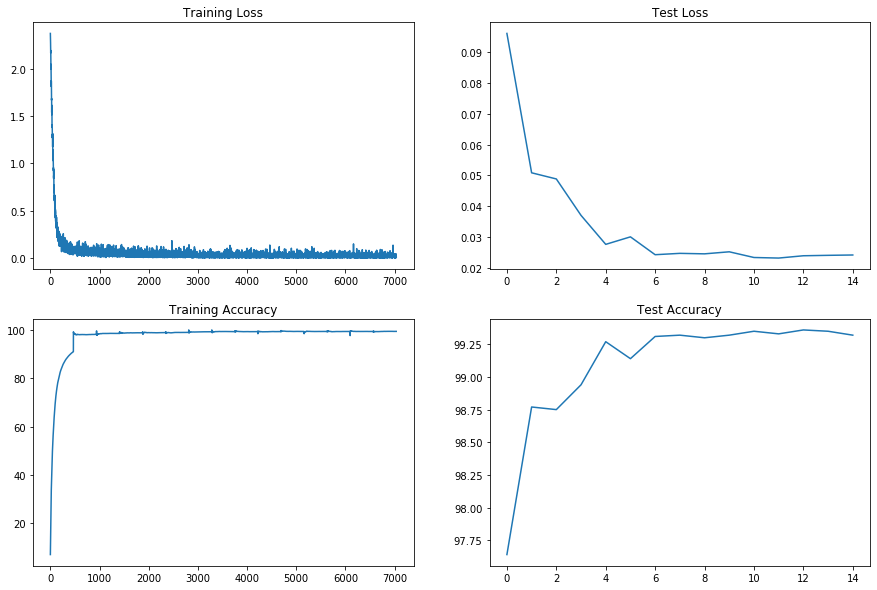

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")